In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["JAX_ENABLE_X64"] = "True"

In [2]:
import jax
from jax import Array

from typing import Callable

import jax.scipy as jsp
import jax.numpy as jnp

from jax import random

import matplotlib.pyplot as plt

from bpd.prior import shear_transformation

In [2]:
def logtarget_ellip(
    e_sheared: Array,
    *,
    data: Array,  # renamed from `e_obs` for comptability with `do_inference_nuts`
    sigma_m: float,
    sigma_e_int:float,
):
    e_obs = data
    assert e_sheared.shape == (2,) and e_obs.shape == (2,)

    prior = jsp.stats.norm.logpdf(e_sheared, loc=0., scale=sigma_e_int).sum()
    likelihood = jnp.sum(jsp.stats.norm.logpdf(e_obs, loc=e_sheared, scale=sigma_m))
    return prior + likelihood

In [80]:
def logtarget_shear(g:Array, *, data: Array, loglikelihood: Callable):
    loglike = loglikelihood(g, e_post=data)
    logprior = jsp.stats.norm.logpdf(g, loc=0, scale=0.01).sum()
    return logprior + loglike

In [154]:
rng_key = random.key(43)
keys = random.split(rng_key, 10)

In [169]:
sigma_e = 1e-2
sigma_e_int = 5e-2
sigma_m=1e-5

g1 = 0.02
g2 = 0.0
true_g = jnp.array([g1, g2])
n_gals = 1000

In [170]:
e = random.normal(keys[0], shape=(n_gals, 2)) * sigma_e
e_sheared = shear_transformation(e, true_g)
e_obs = random.normal(keys[1], shape=(n_gals, 2)) * sigma_m + e_sheared

In [171]:
# get interim ellipticities
from functools import partial
from bpd.chains import run_inference_nuts
from jax import jit
from jax import vmap

_logtarget = partial(logtarget_ellip, sigma_m=sigma_m, sigma_e_int=sigma_e_int)
keys3 = random.split(keys[2], n_gals)
_do_inference_jitted = jit(
    partial(
        run_inference_nuts,
        logtarget=_logtarget,
        n_samples=100,
        initial_step_size=max(sigma_e, sigma_m),
        max_num_doublings=2,
        n_warmup_steps=500,
    )
)
_do_inference = vmap(_do_inference_jitted, in_axes=(0, 0, 0))

# compile
_ = _do_inference(keys3[:2], e_sheared[:2], e_obs[:2])

e_post = _do_inference(keys3, e_sheared, e_obs)


In [172]:
e_post.shape

(1000, 100, 2)

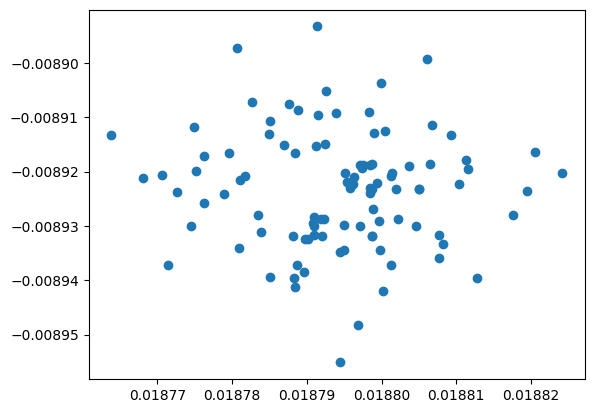

In [173]:
plt.scatter(e_post[2, :, 0], e_post[2, :, 1])

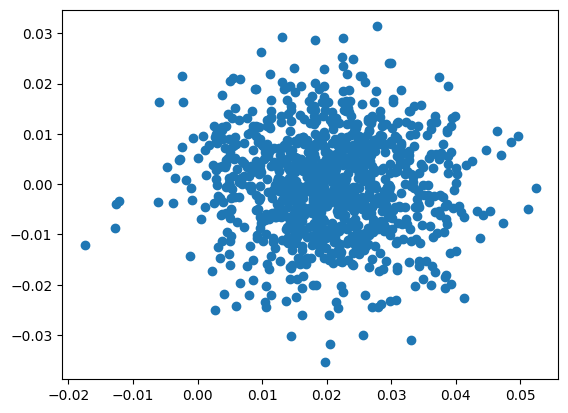

In [174]:
# make sure not hit (-1, 1) boundary
plt.scatter(e_sheared[:, 0], e_sheared[:, 1])

In [175]:
from jax import grad
from bpd.prior import inv_shear_func1, inv_shear_func2, inv_shear_transformation
_grad_fnc1 = vmap(vmap(grad(inv_shear_func1), in_axes=(0, None)), in_axes=(0, None))
_grad_fnc2 = vmap(vmap(grad(inv_shear_func2), in_axes=(0, None)), in_axes=(0, None))
_inv_shear_trans = vmap(inv_shear_transformation, in_axes=(0, None))

def shear_loglikelihood(
    g: Array,
    e_post: Array,
    *,
    sigma_e, 
    sigma_e_int,
):
    # Given by the inference procedure in Schneider et al. 2014
    # assume single shear g
    # assume e_obs.shape == (N, K, 2) where N is number of galaxies, K is samples per galaxy
    # the priors are callables for now on only ellipticities
    # the interim_prior should have been used when obtaining e_obs from the chain (i.e. for now same sigma)
    _, _, _ = e_post.shape  # (N, K, 2)

    denom = jsp.stats.norm.logpdf(e_post, loc=0., scale=sigma_e_int).sum(axis=-1)

    # for num, use trick
    # p(w_n' | g, alpha )  = p(w_n' \cross^{-1} g | alpha ) = p(w_n | alpha) * |jac(w_n / w_n')|

    # shape = (N, K, 2)
    grad1 = _grad_fnc1(e_post, g)
    grad2 = _grad_fnc2(e_post, g)
    absjacdet = jnp.abs(grad1[..., 0] * grad2[..., 1] - grad1[..., 1] * grad2[..., 0])

    e_post_unsheared = _inv_shear_trans(e_post, g)
    num1 = jsp.stats.norm.logpdf(e_post_unsheared, loc=0., scale=sigma_e).sum(axis=-1)
    num = num1 + jnp.log(absjacdet)  # (N, K)
    assert denom.shape == num.shape == absjacdet.shape

    ratio = jsp.special.logsumexp(num - denom, axis=-1)
    return ratio.sum()


In [178]:
_loglikelihood = jit(
    partial(
        shear_loglikelihood,
        sigma_e=sigma_e,
        sigma_e_int=sigma_e_int,
    )
)
_logtarget = partial(logtarget_shear, loglikelihood=_loglikelihood)

_do_inference = partial(
    run_inference_nuts,
    data=e_post,
    logtarget=_logtarget,
    n_samples=3000,
    n_warmup_steps=500,
    max_num_doublings=2,
    initial_step_size=0.1,
)

In [179]:
g_samples = _do_inference(rng_key, true_g)

In [180]:
g_samples.shape

(3000, 2)

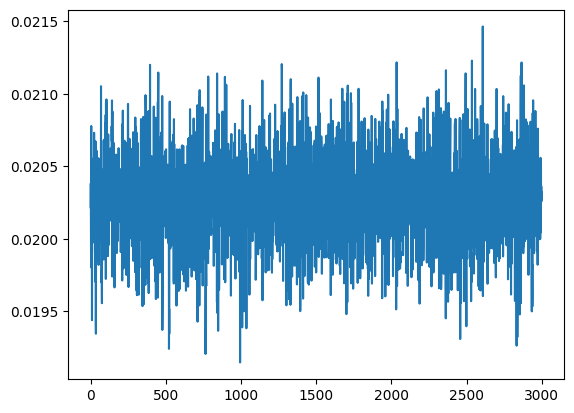

In [181]:
plt.plot(g_samples[:, 0])

In [182]:
g_samples[:, 0].std(), sigma_e/ jnp.sqrt(n_gals), (sigma_e / jnp.sqrt(n_gals)) / jnp.sqrt( 1 + sigma_e**2 / (n_gals * 0.01**2))

(Array(0.00031503, dtype=float64),
 Array(0.00031623, dtype=float64, weak_type=True),
 Array(0.00031607, dtype=float64, weak_type=True))